<a href="https://colab.research.google.com/github/Matteo-Candi/ADM_HW2/blob/Matteo/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - ADM - group 17**

Description

In [2]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import datetime as dt
from scipy import stats

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locations = pd.read_csv('/content/drive/MyDrive/ADM/instagram_locations.csv', sep='\t')

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t')

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t')



--------------------------------------------------------------------------------

# Research Questions

## RQ1

## RQ2

Plot the number of posts for each profile in descending order

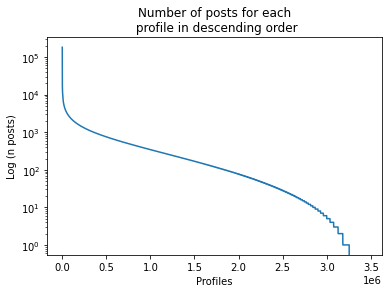

In [ ]:
n_posts = profiles.n_posts.dropna()

plt.plot(np.sort(n_posts)[::-1]);
plt.title('Number of posts for each\n profile in descending order')
plt.ylabel('Log (n posts)')
plt.xlabel('Profiles')
plt.yscale('log')

What posts have the highest number of "likes"?

In [ ]:
most_likes = pd.DataFrame(columns=['post_id', 'numbr_likes'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'numbr_likes']):
    chunk_most_like = chunk.sort_values(by='numbr_likes', ascending=False).head(5)
    most_likes = pd.concat([most_likes, chunk_most_like])

# Reading all dataset chunk by chunk we find, after sorting the values, the highest values in the chunk
# Then we take the highest among the highest.

most_likes.sort_values(by='numbr_likes', ascending=False).head(5)

,post_id,numbr_likes
19624085,Bt3yaXmAM0d,8822952.0
19623988,BuwffB7g8cK,5447066.0
19624082,Buc1gyZAaMQ,5116398.0
19623986,BvcukE8AMuG,4271466.0
39701024,BqSLFVBFLfq,4264745


What posts have the most and the least number of comments?

In [ ]:
most_comment = pd.DataFrame(columns=['post_id', 'number_comments'])
least_comment = pd.DataFrame(columns=['post_id', 'number_comments'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'number_comments']):
    chunk_most = chunk.sort_values(by='number_comments', ascending=False).head(5)
    chunk_least = chunk.sort_values(by='number_comments', ascending=False).tail(5)
    most_comment = pd.concat([most_comment, chunk_most])
    least_comment = pd.concat([least_comment, chunk_least])
  
print('Posts with most comments\n\n', most_comment.sort_values(by='number_comments', ascending=False).head(5))
print('\n\nPosts with least comments\n\n', least_comment.sort_values(by='number_comments', ascending=False).head(5))


# We take all the dataset by chunk and for every chunk, after ordering it, we take the first and the last five.
# In the end we take the highest among the highest and the lowest among the lowest.

Posts with most comments

               post_id number_comments
41873060  Bx2sPAjHviO          488953
12164781  BuGjhWAhAW5          313997
33261751  BJ-rkpTgn1N          257488
11149127  BMtisIxjhtT          214365
9383817   BzOOWj3DfZK          189888


Posts with least comments

               post_id number_comments
77497     BxhcazrhJVo               0
29752487  BwiS3P2h_sm               0
29752484  BwwhHRUganM               0
29499999  Bw4F7e-A3PB               0
29374405  BxWHjO0ntUC               0


Since the least number of comments in a post is 0, there are a lot posts with this value. Also checking the posts with 1 or 2 comments would be useless because for sure there are a lot. Differently the posts most comented are more interesting and show us the boarderline cases like the first that have almost 500k comments.


How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

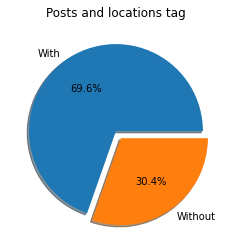

In [ ]:
loc = 0
no_loc = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['location_id']):
    no_loc += chunk.location_id.isna().sum()
    loc += len(chunk)                           # Using chunks we just count the missing values in location_id column


plt.pie([loc - no_loc, no_loc], labels=['With', 'Without'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Posts and locations tag')
plt.show()

How many posts include only photos? How many also have videos?

In [ ]:
n_photos = 0
n_multy = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_type']):
    for el in chunk.post_type:
        if el == 1:
            n_photos +=1            # We just count the number of different values of post_type column
        elif el == 3:
            n_multy += 1

print(f'There are {n_photos} posts that include only photos.')
print(f'There are {n_multy} posts that include also videos.')

There are 41534486 posts that include only photos.
There are 40943 posts that include also videos.


What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

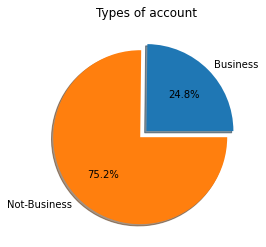

In [ ]:
business = profiles.is_business_account.dropna()
t = sum(business)
f = len(business) - t                                  # We just count the quantity of trues and falses in is_business_account column

plt.pie([t,f], labels=['Business', 'Not-Business'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Types of account')
plt.show()

The percentage of business account tells us that despite the fact that Instagram it's been created as a platform in which to share photos and videos among users, it is also used a lot from business (almost 25% of total account in our dataset) to share their product and advertise.

## RQ3

## RQ4

## RQ5

## RQ6

## RQ7

What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [ ]:
profiles_followers = profiles[['sid', 'followers']]
profiles_followers = profiles_followers[profiles_followers.followers != 0].dropna()

# we remove all the profiles with missing value(1056815) and with 0 followers (22115)

all = 0
tot = 0
for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'numbr_likes']): 
    data = pd.merge(chunk, profiles_followers, left_on='sid_profile', right_on='sid').drop('sid', axis=1)   
    all += (data.apply(lambda x: x.numbr_likes/ x.followers, axis=1) > 0.2).sum()                            
    tot += len(data)

    # merging the chunks and the profiles to get a new dataset with n_likes and n_followers for every post
    # counting all the rows that have (n_likes / n_followers) > 0.2

print(f"The probability is: {round(all/tot, 3) * 100}%")

The probability is: 15.2%


Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [ ]:
profiles = list(profiles.sid)
prof_dict = {k: [] for k in profiles}       # creating a dictionary with all profiles

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'location_id']): 
    chunk = chunk[chunk.sid_profile != -1].dropna()             # cleaning the chunk
    for loc, prof in zip(chunk.location_id, chunk.sid_profile):
        prof_dict[int(prof)].append(loc)            # appending to profiles any locations they visited

count = 0
tot = 0
for item in prof_dict.values():         # counting for every profiles how many times they visited every location where they posted
    d = Counter(item)
    v = [i for i in d.values() if i > 1]        
    count += len(v)                     # counting the locations where they have been more than once
    tot += len(set(item))

print(f"The probability is: {round(count/tot, 3) * 100}%")

The probability is: 18.8%


We compute this  probability supposing that a user posts a post only when he goes in a location. So of course this result can not have sense because a user could also posts something with the same location of the previous posts having taken a picture in the same moment of the previous. So posting a post with a location that is the same of some previous one not imply that the user is back in the same place and so this probability doesn't have any sense.

## RQ8

Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

In [4]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', usecols=['numbr_likes', 'number_comments', 'cts'])

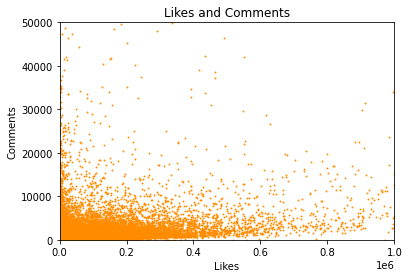

In [ ]:
plt.scatter(posts.numbr_likes, posts.number_comments, color='darkorange', s=.8)
plt.xlim([0, 1000000])      # Here we don't care about outliers but we only want readble informations on the scatterplot so we use appropriate ranges
plt.ylim([0, 50000])
plt.title('Likes and Comments')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.show()

On this plot we don't see any particular correlation between likes and comments. Therefore more likes doesn't mean also more comments, rather we notice that as the likes increase, the comments remain constant.



Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

In [5]:
posts.cts = pd.to_datetime(posts.cts).dt.floor('h').dt.time

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 566.929x396.85 with 0 Axes>

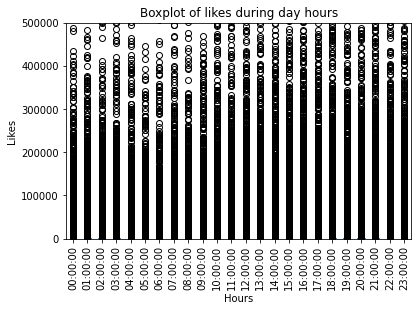

In [6]:
# https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0

plt.figure(figsize=(20/2.54, 14/2.54))
posts.boxplot('numbr_likes', by='cts')
plt.title("Boxplot of likes during day hours")
plt.xlabel("Hours")
plt.ylabel("Likes")
plt.ylim([0, 500000])
plt.suptitle("")
plt.xticks(rotation=90)
plt.grid(b=None)
plt.show()

In [7]:
mean_likes = posts.numbr_likes.groupby(posts.cts).apply(lambda x: x.mean())
med_likes = posts.numbr_likes.groupby(posts.cts).apply(lambda x: x.median())
sd_likes = posts.numbr_likes.groupby(posts.cts).apply(lambda x: x.std())
mean_comments = posts.number_comments.groupby(posts.cts).apply(lambda x: x.mean())
med_comments = posts.number_comments.groupby(posts.cts).apply(lambda x: x.median())
sd_comments = posts.number_comments.groupby(posts.cts).apply(lambda x: x.std())

hours = list(map(str,sorted(list(set(posts.cts))[1:])))

<Figure size 1133.86x850.394 with 0 Axes>

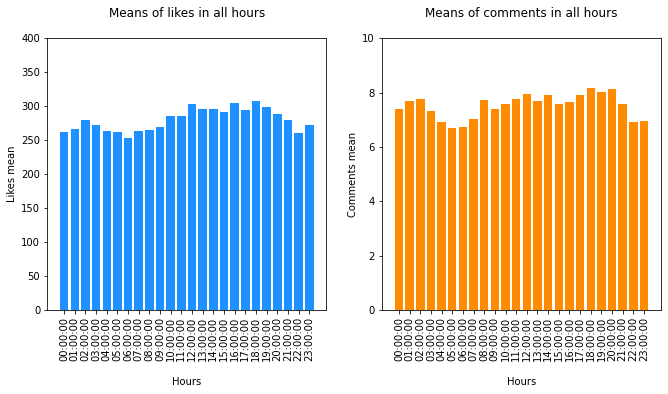

In [79]:
plt.figure(figsize=(40/2.54, 30/2.54))

fig, ax = plt.subplots(1,2, figsize=(11, 5))
ax[0].bar(hours,list(mean_likes), color="dodgerblue")
ax[0].set(title="Means of likes in all hours\n", xlabel="\nHours", ylabel="Likes mean", ylim=[0, 400])
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(hours,list(mean_comments), color="darkorange")
ax[1].set(title="Means of comments in all hours\n", xlabel="\nHours", ylabel="Comments mean", ylim=[0, 10])
ax[1].tick_params(axis='x', rotation=90)

plt.show()

In [80]:
sd_likes

cts
00:00:00    5717.869802
01:00:00    5273.066745
02:00:00    7171.448220
03:00:00    7880.886911
04:00:00    5998.921553
05:00:00    6674.830439
06:00:00    5206.088039
07:00:00    5629.867019
08:00:00    5264.376168
09:00:00    5014.810088
10:00:00    5440.879248
11:00:00    5083.313460
12:00:00    5496.351938
13:00:00    5127.146361
14:00:00    5673.831889
15:00:00    4890.642229
16:00:00    6751.024402
17:00:00    5197.773579
18:00:00    9068.842433
19:00:00    5761.855300
20:00:00    5502.338894
21:00:00    6522.864224
22:00:00    6679.699871
23:00:00    7026.444593
Name: numbr_likes, dtype: float64

What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

The mean is: 4783.1
The mode is: 50.0

    Quantile   Value
0        10    65.0
1        20   129.0
2        30   204.0
3        40   294.0
4        50   412.0
5        60   570.0
6        70   813.0
7        80  1201.0
8        90  2531.0


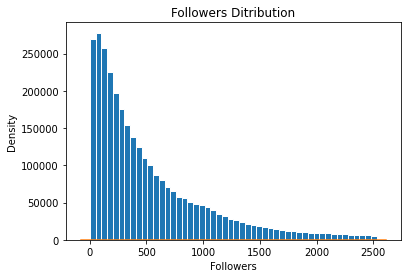

In [ ]:
followers = np.array(profiles.followers.dropna())
followers= followers[followers != 0]        # 22115 cases
followers= followers[followers != 1]        # 9071 cases

mean = round(followers.mean(), 2)

stats = Counter(followers)
mode = max(stats, key=stats.get)

rng = np.arange(10,91,10)
quant = np.percentile(followers,rng)
data = {'Quantile': rng, 'Value': quant}
quantiles = pd.DataFrame(data)

print("The mean is:", mean)
print("The mode is:", mode)
print("\n", quantiles)

follower = followers[followers < quant[-1]]

plt.hist(follower, bins = 50, ec="white")      # We plot just the 90% of lowest units to have a clear rapresentation of the followers distribution
plt.title("Followers Ditribution")
plt.xlabel("Followers")
plt.ylabel("Density")
plt.show()


If we leave the profiles with 0 and 1 followers (31186 cases) the mode will be 0 and the mean value will decrease to 4739.9 but the form of the distribution will be almost the same. From the chart we can see how, incresing the number of the followers, the quantity of profiles with this number decrease very quickly. This implies that there are a lot of profiles with a low number of followers and only a few profiles with many followers.

What are histograms, bar plots, scatterplots and pie charts used for?

* <ins> Histogram </ins>: It's used to represent the distribution of a single continuous variable. The bins are the intervals in which this variable it's been splitted and the high of the column represents how many time a value of this variable occurred in that interval.
* <ins> Bar Plot </ins>: This chart corresponding to the Histogram for discrete variables. Every bin represents a value which can be assumed by the variable and the high of the column tells us how many times the variable assumes that value.
* <ins> Scatterplot </ins>: This chart is used to plot a series of units that have two different attributes. Thanks to this we can see how the variables behave with each other, if there is some type of correlation.
* <ins> Pie Chart </ins>: The pie chart is another way to represent what values a discrete variable takes  and, reporting these values of the respective relative frequencies, give use a visual the information what portion of the total every different value takes.

What insights can you extract from a Box Plot?

The Box Plot is a type of graph used to visually summarize many informations of a continuous variable: 
* the horizontal line insiede the box represent the mean of the distribution;
* the edges of the box represents the first and the third quartile (25% and 75% of the units)
* the horizontals line at the end of the vertical ones are a range defined a range $(Q_3 \pm 1.5 * Q_1)$ outside of which we find the outliers.

Watching this plot we can have visually a first information about the variable distibution.

# Bonus Points

--------------------------------------------------------------------------------

# Command Line Question

--------------------------------------------------------------------------------

# Algorithmic Question

## AQ1

In [ ]:
ciao

## AQ2